<div align="center"><h1> Titanic - Machine Learning from Disaster </h1></div> 

## Scope of Work

|Deliverable|Tasks                    |
|:----------:|:------------------------|
|1. Defining the problem|<ul><li>Producing a scope of work document</li><li>Framing a problem statement</li></ul>|
|2. Gather and prepare the data for modeling|<ul><li>Download and view the testing and training data</li><li>Research and apply the right data manipulation tools for processing and analysis</li><li>Wrangle and clean the data to a point where it can be worked with effectively in modeling</li></ul>|
|3. Model|<ul><li>Apply the correct algorithm(s) that fulfill the objectives of the project</li><li>Train and test</li></ul>|
|4. Reiterate|<ul><li>Based on the results, look back and reiterate on anything that may require improvement to achieve a more accurate model</li></ul>|

# Background & Problem Statement
This case is part of a competition hosted by Kaggle, with an overview of the project found [here](https://www.kaggle.com/c/titanic/overview). On April 15, 1912, 1502 out of the 2224 lives on board the Titanic were snuffed out after the ship collided with an iceberg. Those who died and those who survived tied their fate to an abundance of factors. The challenge is to come up with a predictive model that accurately classifies a passenger's fate of survival or death.

# Gathering and Preparing the Data for Exploration

## Downloading and Viewing the Testing and Training Data

Since Kaggle is providing the data, we don't need to concern ourselves with ROCC (reliable, original, comprehensive, current and credible) standards. We'll jump right into the data and make some initial observations.

Apart from the target variable we're interested in determining (Survived), the test and train sets match up feature wise.

## Applying the Right Tools

The file sizes are fairly small, so we'll do all of our data manipulation and analysis with R, a general purpose programming language perfect for statistical analysis and visualization. 

Let's look at our data sets

In [523]:
options(warn=-1)

# importing the libraries we'll need
library(Amelia)
library(aod)
library(dplyr)
library(Hmisc)
library(ggplot2)
library(tidyr)
library(fastDummies)
library(tidyverse)
library(stringr)

# import the included csv files into separate dataframes
df_test <- read.csv(file = 'test.csv')
df_train <- read.csv(file = 'train.csv')

# get the dimension of our frames
cat("test data rows and columns: ", dim(df_test), "\n")
cat("training data rows and columns: ", dim(df_train))

# combine our data frames (except for the Survived variable) for a more concrete analysis
df_all = rbind(subset(df_train, select = -c(Survived)),df_test)

test data rows and columns:  418 11 
training data rows and columns:  891 12

Our training to test set size ratio is roughly 70:30, which is ideal given our small dataset size.

Let's see what kind of values fill up these variables

In [524]:
summary(df_all)

  PassengerId       Pclass          Name               Sex           
 Min.   :   1   Min.   :1.000   Length:1309        Length:1309       
 1st Qu.: 328   1st Qu.:2.000   Class :character   Class :character  
 Median : 655   Median :3.000   Mode  :character   Mode  :character  
 Mean   : 655   Mean   :2.295                                        
 3rd Qu.: 982   3rd Qu.:3.000                                        
 Max.   :1309   Max.   :3.000                                        
                                                                     
      Age            SibSp            Parch          Ticket         
 Min.   : 0.17   Min.   :0.0000   Min.   :0.000   Length:1309       
 1st Qu.:21.00   1st Qu.:0.0000   1st Qu.:0.000   Class :character  
 Median :28.00   Median :0.0000   Median :0.000   Mode  :character  
 Mean   :29.88   Mean   :0.4989   Mean   :0.385                     
 3rd Qu.:39.00   3rd Qu.:1.0000   3rd Qu.:0.000                     
 Max.   :80.00   Max.   :8

In [525]:
# standard deviations of our numerical variables
sapply(df_all, sd)

PassengerId      Pclass        Name         Sex         Age       SibSp 
378.0200612   0.8378360          NA          NA          NA   1.0416584 
      Parch      Ticket        Fare       Cabin    Embarked 
  0.8655603          NA          NA          NA          NA

And let's get a sense of the unique values for each categorical variable (which have a character data type).

In [526]:
# convert empty strings into nulls
df_all[df_all == ""] <- NA

# count the number of unique values for each variable
cat("Number of unique values:\n\n")
cat("Embarked:", length(unique(na.omit(df_all[["Embarked"]]))),"\n")
cat("Cabin:", length(unique(na.omit(df_all[["Cabin"]]))),"\n")
cat("Ticket:", length(unique(na.omit(df_all[["Ticket"]]))),"\n")
cat("Name:", length(unique(na.omit(df_all[["Name"]]))))

Number of unique values:

Embarked: 3 
Cabin: 186 
Ticket: 929 
Name: 1307

As well as the histograms of our numerical features, to get a sense of each variable's distribution

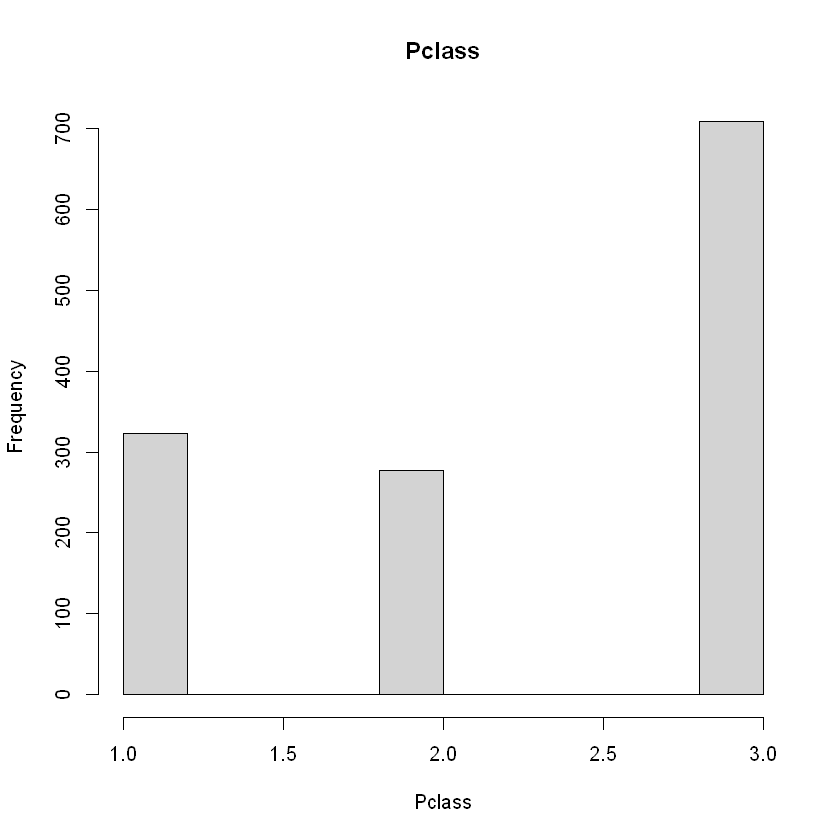

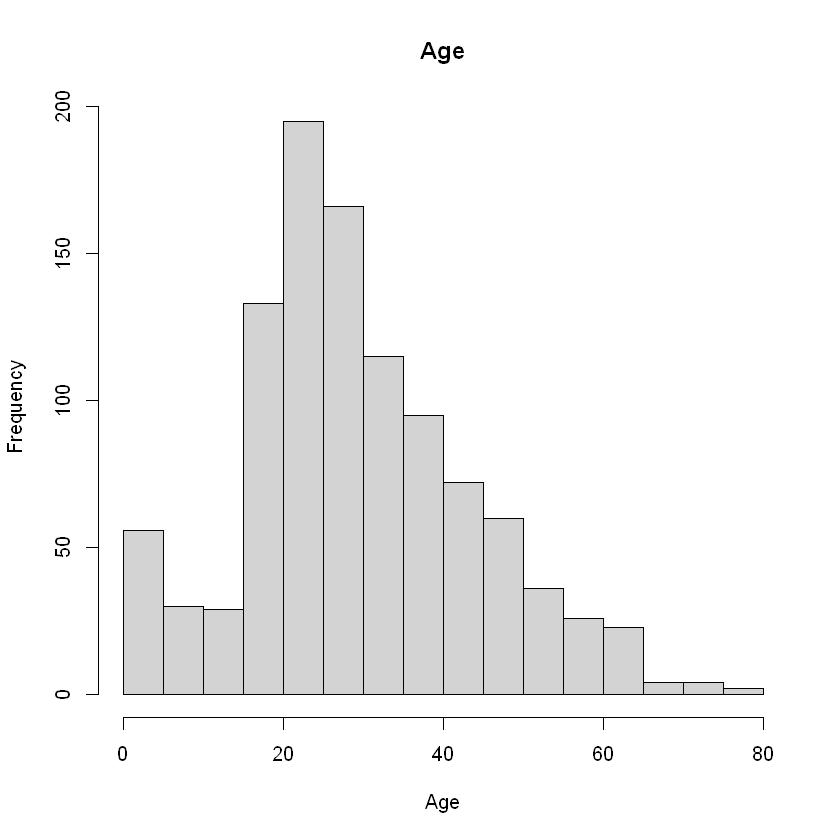

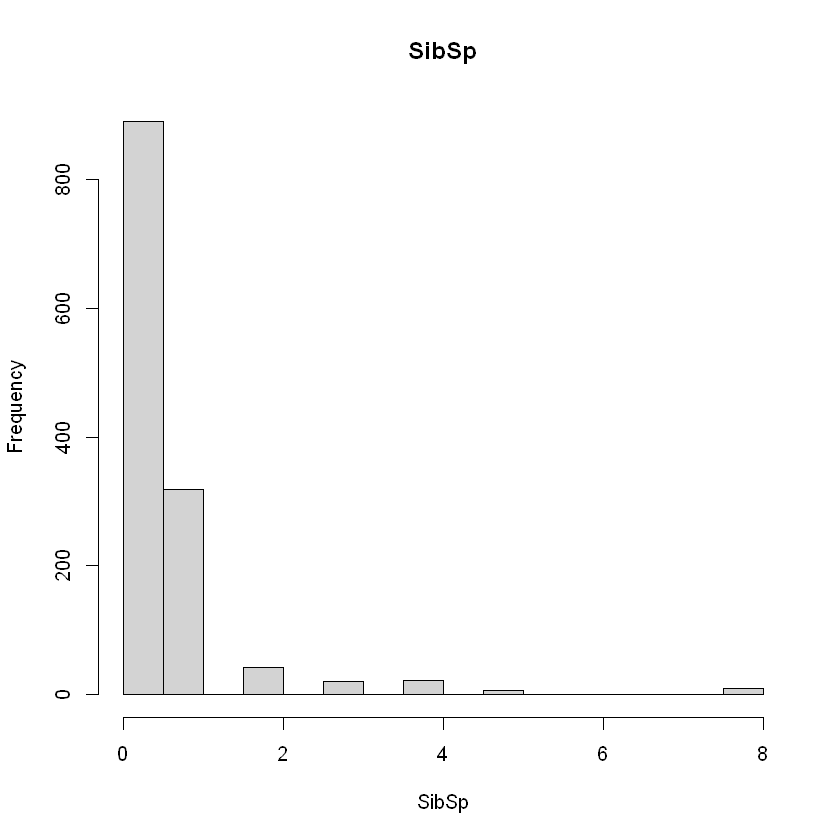

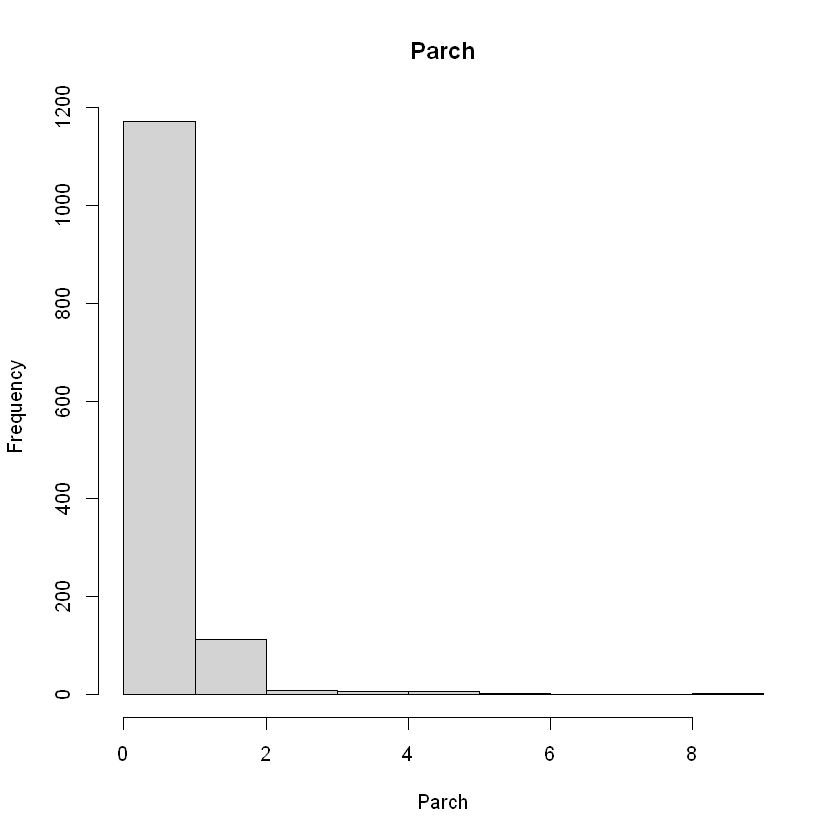

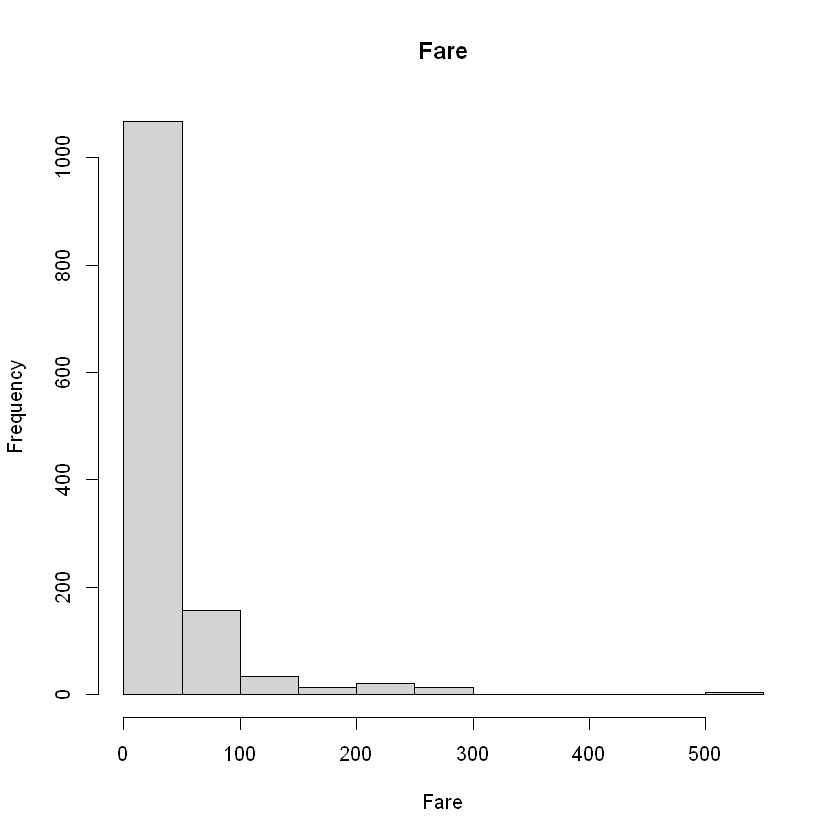

In [527]:
for (col in colnames(df_all[,2:11])) {
    if (is.numeric(df_all[[col]])){
        hist(df_all[[col]], main = col, xlab = col)
    }
}

Now, let's define our variables, mention their associated types and any expected feature transformations that will arise later. 

<b>Survived (0 = Dead or 1 = Alive)</b>: Dichotomous
    
This will be our target variable, which we'll calculate with the help of independent variables.

<b>PassengerId</b>: Irrelevant

Our training set consists of passengers with IDs between 1 and 891, with the test set between 892 and 1309. These IDs are presumably random unique identifiers for each person on board - so it doesn't represent a chronological ordering to passenger embarkment. This variable is excluded from our analysis and model since it has no bearing over a passenger's survivability. 

<b>Pclass (1 = Upper class, 2 = Middle class, 3 = Lower class)</b>: Ordinal

Short for a passenger's ticket class, Pclass represents a passenger's socio-economic status.
    
<b>Sex (Male, Female)</b>: Dichotomous
    
There is significantly more males than females on board, nearly 2:1. Sex will need to be converted to dummy variables.
    
<b>Age</b>: Continuous
    
Nearly 20% of passengers do not have a recorded age. Age will need to be converted to a discrete variable via binning. 
    
<b>SibSp</b>: Discrete
    
Represents the number of related siblings and spouses on board.
    
<b>Parch</b>: Discrete  
    
Represents the number of related parents and children on board.
   
<b>Fare</b>: Continuous
    
Represents the amount a passenger paid for admission. Fare will need to be converted to a discrete variable via binning. 
    
<b>Cabin</b>: Nominal, Insufficient data
    
Represents the cabin accommodations in letter/number format. It contains quite a few null values in either set (nearly ~80%). With little to no data to work with, keeping this variable will likely negatively affect our model's performance. This column will be dropped.
    
<b>Embarked (C = Cherbourg, Q = Queenstown, S = Southampton)</b>: Nominal
    
This represents the port of embarkation. Embarked will require conversion into dummy variables.
    
<b>Name</b>: Nominal, Semi-irrelevant

A passenger's name includes several potentially relevant features like a person's title or marital status (Miss vs Mrs). If we engineer these features into dummy variables, they may prove to be useful to our model. 

<b>Ticket</b>: Nominal, Potentially irrelevant

You would think that ticket numbers would be unique to each passenger, but we find that there are several identical ticket numbers associated with different PassengerIds. These numbers could potentially have some influence on our target variable if the variable holds any significance beyond a passenger's admission. I have not been able to find any important associations, so we will drop this column from our analysis.
    
Let's move on to data cleaning

## Clean and Wrangle for Analysis

Let's clean our data by removing egregious values and handling missing values. We'll also apply some feature engineering and convert our variables into a format that can be used in our prediction model.

1. Cleaning: Correct egregious values - deleting invalid data, dealing with duplicates and verifying outliers

Let's drop our cabin column and then check to see if there are any concerning duplicates

In [528]:
# drop Cabin from our dataframes
df_all <- subset(df_all, select = -c(Cabin))
df_test <- subset(df_test, select = -c(Cabin))
df_train <- subset(df_train, select = -c(Cabin))

# checking for duplicate PassengerIds
df_test$PassengerId[duplicated(df_test$PassengerId)]
df_train$PassengerId[duplicated(df_train$PassengerId)]

integer(0)

integer(0)

All of our passengers are referenced by unique passenger IDs. However, we did note that there were several identical ticket numbers, so let's verify that these rows aren't problematic by comparing them side by side.

In [529]:
df <- df_test[duplicated(df_test["Ticket"]) | duplicated(df_test["Ticket"], fromLast = TRUE),]
head(df[order(df["Ticket"]),],8)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>
369,1260,1,"Gibson, Mrs. Leonard (Pauline C Boeson)",female,45.0,0,1,112378,59.40,C
403,1294,1,"Gibson, Miss. Dorothy Winifred",female,22.0,0,1,112378,59.40,C
75,966,1,"Geiger, Miss. Amalie",female,35.0,0,0,113503,211.50,C
76,967,1,"Keeping, Mr. Edwin",male,32.5,0,0,113503,211.50,C
219,1110,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.50,C
408,1299,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.50,C
142,1033,1,"Daniels, Miss. Sarah",female,33.0,0,0,113781,151.55,S
307,1198,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0,1,2,113781,151.55,S


Nothing seems out of the ordinary.

All other columns are non-unique variables, so we'll stop here and move on to look at any significant numerical outliers, starting with passenger fares followed by passenger age.

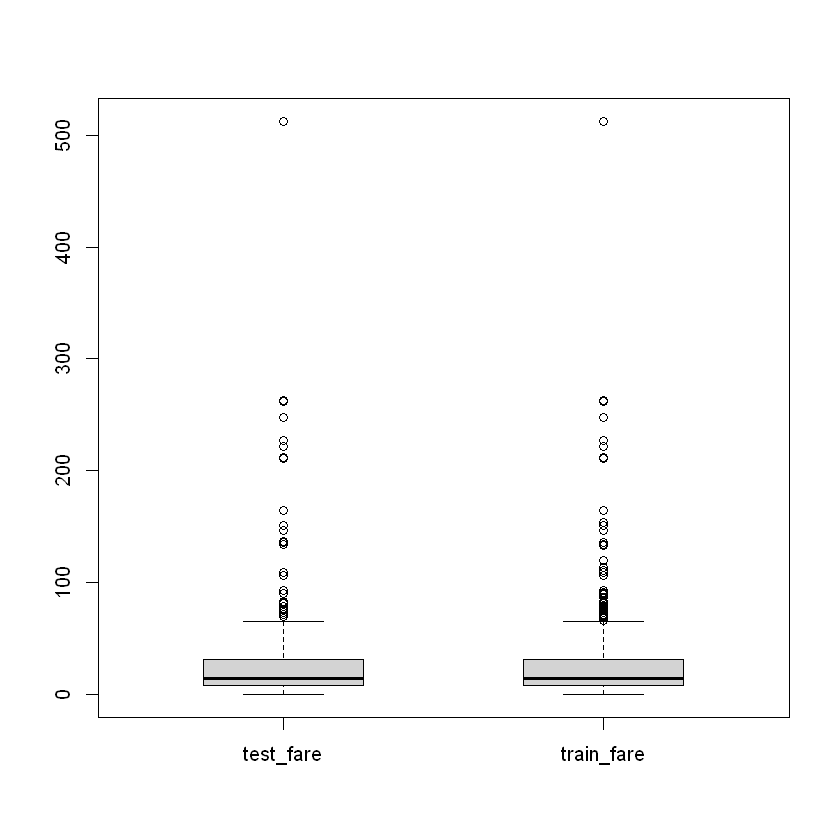

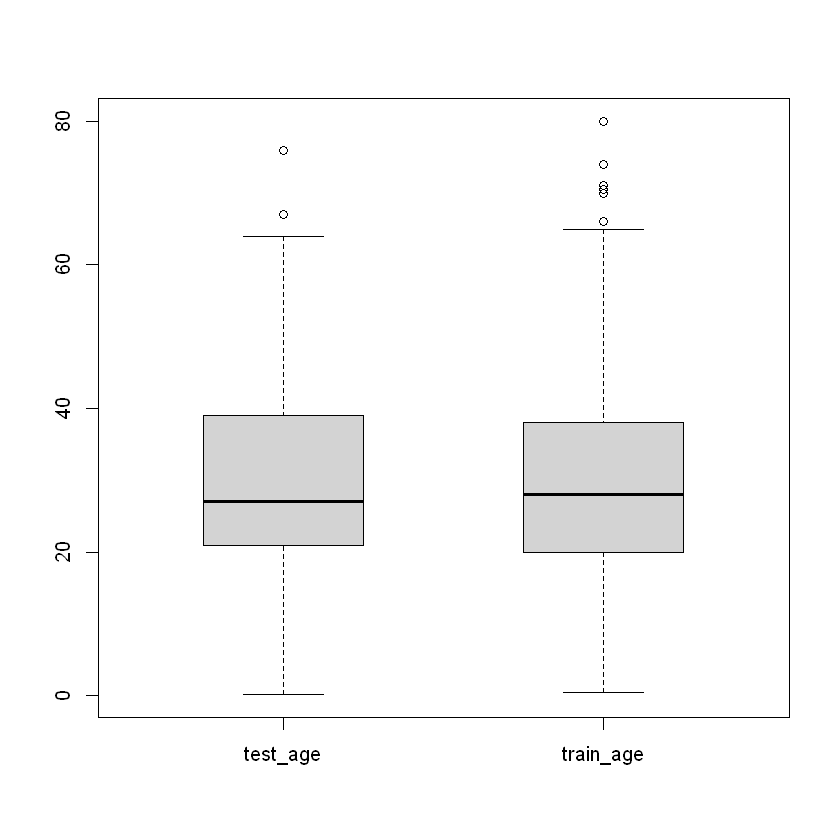

In [530]:
boxplot(list(test_fare = df_test$Fare, train_fare = df_train$Fare), boxwex = .5)
boxplot(list(test_age = df_test$Age, train_age = df_train$Age), boxwex = .5)

There are several potentially problematic outliers that may be too unrealistic, namely the fares that are above $200 USD. We can get a sense of whether these ticket prices actually legitimate if they align correctly with the associated passenger's socio economic status. 

In [531]:
# filter individuals who have paid a fare greater or equal to $200 USD
df_test[df_test$Fare >= 200, c("Pclass","Fare")]
df_train[df_train$Fare >= 200, c("Pclass","Fare")]

,Pclass,Fare
,<int>,<dbl>
25,1,262.3750
54,1,263.0000
60,1,262.3750
65,1,262.3750
70,1,263.0000
75,1,211.5000
76,1,211.5000
82,1,221.7792
115,1,221.7792


,Pclass,Fare
,<int>,<dbl>
28,1,263.0000
89,1,263.0000
119,1,247.5208
259,1,512.3292
300,1,247.5208
312,1,262.3750
342,1,263.0000
378,1,211.5000
381,1,227.5250


Social classes seem to line up with the high fares, so we'll keep the Fare outliers in our sets.

Looking back at the outliers in our age variable, it's fair to assume that there could have been a few passengers that were around the age of 80 on the ship. So let's move on.

2. Cleaning: Handling missing values

Let's check the extent of missing data in our data sets

In [532]:
# First, let's mutate any empty strings into NA's
df_all[df_all == ""] <- NA
df_train[df_train == ""] <- NA
df_test[df_test == ""] <- NA
# And now we can sum the number of NA's in each column
cat("Missing values in:\n\nTraining data set columns:\n-------------------------")
sapply(df_train, function(x) sum(is.na(x)))
cat("Testing data set columns:\n-------------------------")
sapply(df_test, function(x) sum(is.na(x)))

Missing values in:

Training data set columns:
-------------------------

PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare    Embarked 
          0           0           0           0           2

Testing data set columns:
-------------------------

PassengerId      Pclass        Name         Sex         Age       SibSp 
          0           0           0           0          86           0 
      Parch      Ticket        Fare    Embarked 
          0           0           1           0

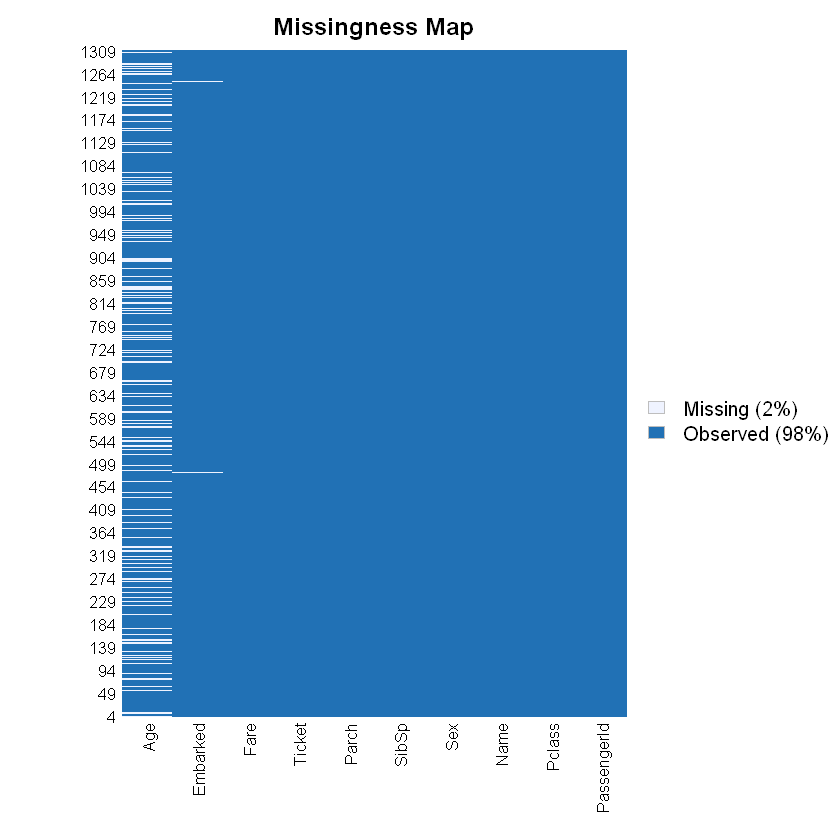

In [533]:
missmap(df_all)

The brunt of our missing values comes from Age. There's also a few among Embarked and Fare between the two data sets. We want to avoid keeping any of these nulls since they're going to be detrimental to our predictive algorithm. We'll choose how to handle each case based on how it will improve our model's accuracy. For starter's, we'll it keep it simple and attempt to use basic methodologies to replace or remove NA's. Upon reiteration, we can test and see if there is more merit to using any other approach.

1. Training data - Embarked: 2 missing values

In [534]:
# select the rows in the training set with NA in embarked
df_train[is.na(df_train$Embarked),]

# find each unique possible value to embarked
cat("Unique values of Embarked:",unique(na.omit(df_all$Embarked)))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>
62,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,NA
830,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,NA


Unique values of Embarked: S C Q

For the sake of simplicity and assuming that we can't infer the value of Embarked based on other variables, let's assign the most common embarked value among the two sets to the rows above that contain nulls.

In [535]:
# there's no built-in function for mode, so let's use this to find the most common variable value
mode <- function(vec) {
  unique_vec <- unique(vec)
  unique_vec[which.max(tabulate(match(vec, unique_vec)))]
}

cat("Mode of Embarked:", mode(df_all$Embarked))

Mode of Embarked: S

In [536]:
# assign 'S' to replace the NA values of Embarked
df_train[is.na(df_train$Embarked), c("Embarked")] <- 'S'
df_all[is.na(df_all$Embarked), c("Embarked")] <- 'S'

2. Testing data - Fare: 1 missing value

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>
153,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,S


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   7.896  14.454  35.627  31.500 512.329       1 

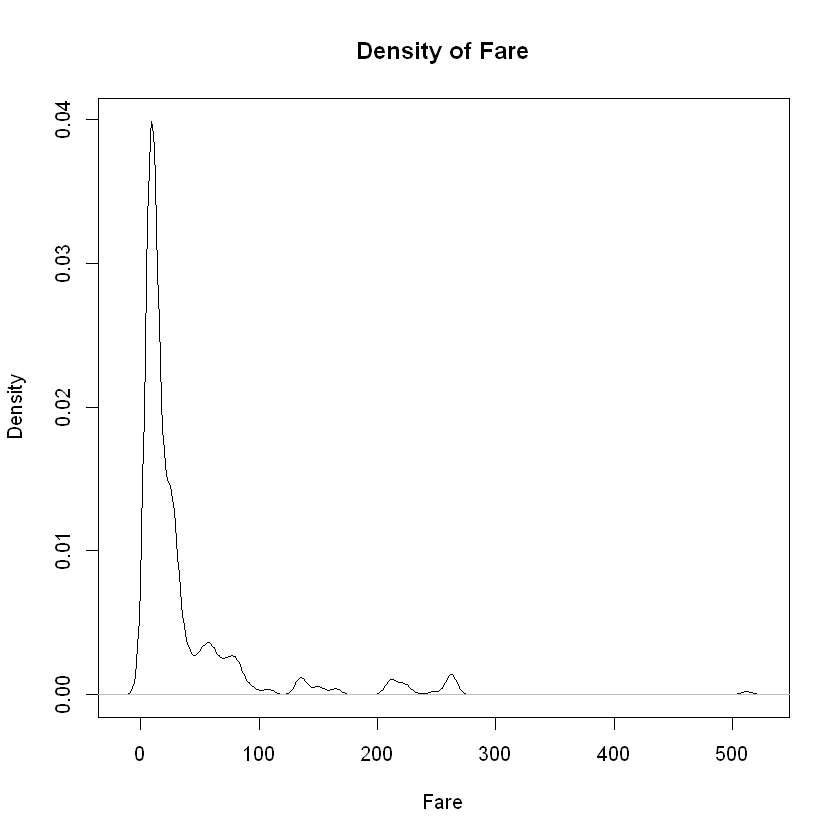

In [537]:
# select the rows in the training set with NA in Fare
df_test[is.na(df_test$Fare),]

# let's take a look at the distribution
plot(density(na.omit(df_test$Fare)),
    main = "Density of Fare",
    xlab = "Fare",
    ylab = "Density")

summary(df_test$Fare)

Let's use the median to replace the NA

In [538]:
# assign the median to replace the singular NA value of Fare in the df_test set
df_test[is.na(df_test$Fare), c("Fare")] <- median(na.omit(df_test$Fare))
df_all[is.na(df_all$Fare), c("Fare")] <- median(na.omit(df_all$Fare))

3. Both sets - Age: 263 missing values between the two sets

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.17   21.00   28.00   29.88   39.00   80.00     263 

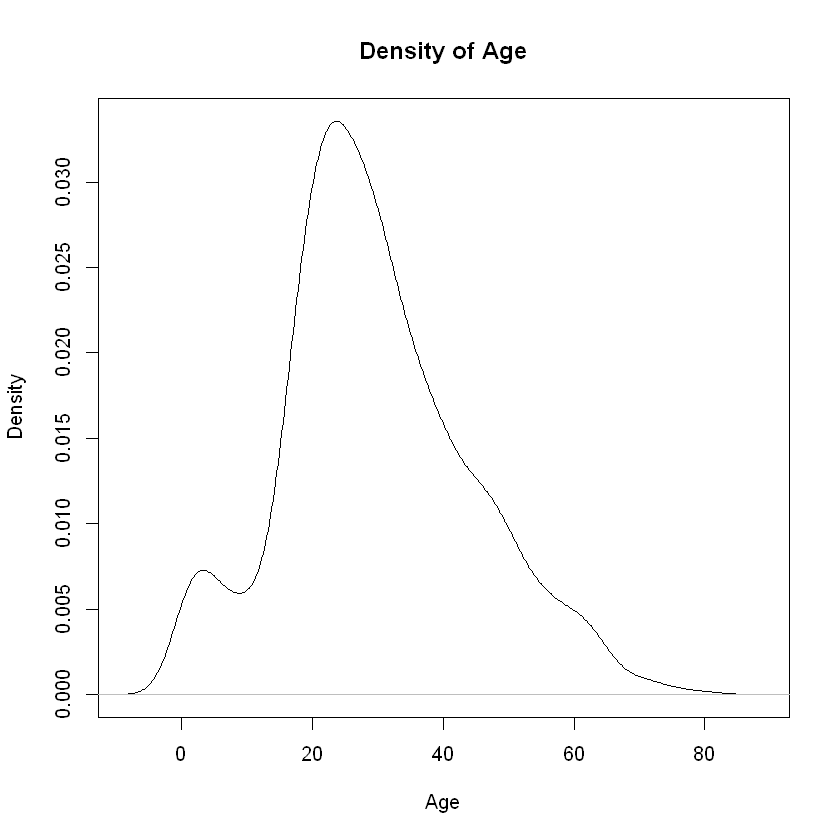

In [539]:
# let's take a look at the distribution in both sets
plot(density(na.omit(df_all$Age)),
    main = "Density of Age",
    xlab = "Age",
    ylab = "Density")

summary(df_all$Age)

Again, let's use the median to replace these NA's

In [540]:
# assign the median to replace the NA values of Age in both sets
df_test[is.na(df_test$Age), c("Age")] <- median(na.omit(df_all$Age))
df_train[is.na(df_train$Age), c("Age")] <- median(na.omit(df_all$Age))
df_all[is.na(df_all$Age), c("Age")] <- median(na.omit(df_all$Age))

<b>3. Data Wrangling - Feature engineering</b>

There are several features that can be engineered which stand out as potentially meaningful.

<ul>1. Accompanied </ul>

Parch and SibSp tell us the number of relatives a passenger has on board with them. It's arguably important to differentiate individuals with or without accompaniment as a crucial factor towards death or survival in our algorithm.

<ul>2. Prefix </ul>

A lot of information can be garnered from a passenger's prefix. For females, we can discern if they are married (Mrs.) or not (Miss.). Men of some status may also have the prefix "Master." or "Don." attributed to them, while others simply have the general "Mr." prefix. We need to consider the level of influence these backgrounds have on a passenger's chance of survival.

<ul>3. FamilySize </ul>

Another important factor is the size of each passenger's family on board. This considers the impact of SipSp and Parch together on a passenger's fate.

In [541]:
# Let's begin with seting up our prefixes

# extract prefixes 
df_train$Prefixes <- str_extract(df_train$Name,"(?<=, ).+(?=\\.)")

# Let's get a sense of the frequencies to see if there are errors or outliers
df_train %>% count(Prefixes)

Prefixes,n
<chr>,<int>
Capt,1
Col,2
Don,1
Dr,7
Jonkheer,1
Lady,1
Major,2
Master,40
Miss,182


This list requires a little bit of cleaning and further categorization, so let's take care of the following issues:


<ul>1. "Mme", "Ms"/"Mlle" are the French prefixes for Madame (Mrs) and Mademoiselle (Miss), let's convert them into their English equivalents</ul>
<ul>2. Mrs. Martin's prefix was not extracted correctly since she had two full stops in her name due to a shortened middle name. Let's change that cell to be "Mrs"</ul>
<ul>3. Jonkheer is a Dutch honorific of female nobility, we'll bin that into a category called Nobility</ul>
<ul>4. Countess, Lady and Don are also titles of nobility - they presumingly belong to the nobility category</ul>
<ul>5. Capt, Col and Major are all titles that indicate various levels of rank in the military, we'll bin these into a category called Military</ul>
<ul>6. Sir is not considered an order of nobility, but is an honor given to a man who has been of exceptional service to a nation. Since there aren't any other passengers with the same title and there aren't any notable suitable categories associated with the background of the title, we'll tag him as a "Mr".</ul>

In [542]:
# fixing the french prefixes to english
df_train$Prefixes[df_train$Prefixes == "Mme"] <- "Mrs"
df_train$Prefixes[df_train$Prefixes == "Ms" | df_train$Prefixes == "Mlle"] <- "Miss"

# replacing Mrs. Martin (Elizabeth L with Mrs
df_train$Prefixes[df_train$Prefixes == "Mrs. Martin (Elizabeth L"] <- "Mrs"

# categorizing noble titles
nobles <- df_train$Prefixes == "Jonkheer" | df_train$Prefixes == "the Countess" | df_train$Prefixes == "Lady" | df_train$Prefixes == "Don"  
df_train$Prefixes[nobles] <- "Noble"

# replacing Sir with Mr
df_train$Prefixes[df_train$Prefixes == "Sir"] <- "Mr"

# categorizing military officers
military <- df_train$Prefixes == "Major" | df_train$Prefixes == "Col" | df_train$Prefixes == "Capt"
df_train$Prefixes[military] <- "Officer"

# let's check the frequencies again to see if everything lines up
df_train %>% count(Prefixes)

Prefixes,n
<chr>,<int>
Dr,7
Master,40
Miss,185
Mr,518
Mrs,126
Noble,4
Officer,5
Rev,6


In [543]:
# Now let's do the familysize column
df_train$FamilySize <- df_train$SibSp + df_train$Parch

# let's check the frequencies
df_train %>% count(FamilySize)

# and finally, the accompanied column
df_train <- df_train %>%
  mutate(Accompanied = 
         case_when(FamilySize > 0 ~ 1,
                   FamilySize == 0 ~ 0)
  )

# let's check the frequencies
df_train %>% count(Accompanied)

FamilySize,n
<int>,<int>
0,537
1,161
2,102
3,29
4,15
5,22
6,12
7,6
10,7


Accompanied,n
<dbl>,<int>
0,537
1,354


4. Data Wrangling - Discrete Binning

Let's turn the continuous variables 'Age' and 'Fare' into bins to make them compatible to future modeling

In [544]:
# Starting with Age

# Let's do the binning by the stages of life

# Infant = (0, 2] years
# Toddler = (2, 5] years
# Child = (5, 13] years
# Teen = (13, 20] years
# Young Adult = (20, 35] years
# Adult = (35, 60] years
# Senior = (60, ~100] years 

intervals <- c(0, 2, 5, 13, 20, 35, 60, 100)
interval_names <- c("Infant", "Toddler", "Child", "Teen", "Young Adult", "Adult", "Senior")

df_train$AgeBins <- cut(df_train$Age, breaks = intervals, labels = interval_names)

# let's check the frequencies
df_train %>% count(AgeBins)

AgeBins,n
<fct>,<int>
Infant,24
Toddler,20
Child,27
Teen,108
Young Adult,495
Adult,195
Senior,22


In [545]:
# and now Fare
n_bins <- round(sqrt(length(df_train$Fare)))
df_train$FareBins <- cut(df_train$Fare, breaks = n_bins, include.lowest = TRUE)

# let's check the frequencies
df_train %>% count(FareBins)

FareBins,n
<fct>,<int>
"[-0.512,17.1]",496
"(17.1,34.2]",191
"(34.2,51.2]",45
"(51.2,68.3]",45
"(68.3,85.4]",48
"(85.4,102]",13
"(102,120]",11
"(120,137]",11
"(137,154]",9


In [546]:
#### REVISIT TO ENHANCE EFFICIENCY ABOVE ############################################################################

### CATEGORIZATION OCCURS AT CSV_READ ###

# let's include the variables above in our dataframes 

# df_train2 <- df_train
# df_test2 <- df_test
# datasets <- list(df_train2, df_test2)

# for df in datasets{
#     df['FamilySize'] <- 1 + df['SibSp'] + df['Parch'] 
#     df['Accompanied'] <- ifelse(df['FamilySize'] == 1, 0, 1)
#     df['Prefix']
# }
# df_train2['FamilySize'] <- 
# df_train2['Accompanied'] <- 1

####################################################################################################################

In [547]:
colnames(df_train)

[1] "PassengerId" "Survived"    "Pclass"      "Name"        "Sex"        
 [6] "Age"         "SibSp"       "Parch"       "Ticket"      "Fare"       
[11] "Embarked"    "Prefixes"    "FamilySize"  "Accompanied" "AgeBins"    
[16] "FareBins"

Lets convert our desired columns into dummies and drop what won't be in the final equation

<b> Y = Survival </b> 

X = Pclass dummies, Sex dummies, SibSp, Parch, Fare dummies, Embarked dummies, FamilySize, Prefixes dummies, AgeBins dummies, FareBins dummies, Accompanied dummies

In [548]:
# drop irrelevant columns
train_X <- subset(df_train, select = -c(PassengerId, Name, Fare, Age, Ticket))

# get our dummies set up 
train_X <- dummy_cols(train_X,
                      select_columns = c('Sex', 'Embarked', 'Pclass', 'Embarked', 'Accompanied', 'AgeBins', 'FareBins'),
                      remove_selected_columns = TRUE,
                     )

# Model

## Apply the correct algorithm(s) that fulfill the objectives of the project

Let's keep things simple and use <a href="https://en.wikipedia.org/wiki/Logistic_regression">logistic regression</a> to model the probability of survival.

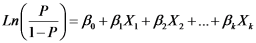

where Pr(Survived = Alive|Dead)

## Train and test 

In [549]:
# df_train <- subset(df_train, select = -c(PassengerId, Name, Age, Fare, Ticket))

In [550]:
# sapply(df_train, class)

In [551]:
# for (col in c("Pclass", "Sex", "Embarked", "Prefixes", "Accompanied")){
#     df_train[col] <- as.factor(df_train[col])
# }

In [552]:
# contrasts(df_train$Pclass)

In [553]:
mylogit <- glm(Survived ~ ., 
               data = train_X, 
               family = "binomial"(link = "logit"))
summary(mylogit)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = train_X)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5028  -0.5021  -0.3551   0.5215   2.6749  

Coefficients: (22 not defined because of singularities)
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)                12.8124  1131.2037   0.011 0.990963    
SibSp                      -0.8828     0.2048  -4.310 1.63e-05 ***
Parch                      -0.4237     0.1763  -2.404 0.016216 *  
PrefixesMaster              4.2764     1.2202   3.505 0.000457 ***
PrefixesMiss              -28.6619  1694.3293  -0.017 0.986503    
PrefixesMr                  0.3619     1.0445   0.346 0.728988    
PrefixesMrs               -27.9107  1694.3293  -0.016 0.986857    
PrefixesNoble             -14.7870  1264.9205  -0.012 0.990673    
PrefixesOfficer             1.1904     1.4149   0.841 0.400184    
PrefixesRev               -14.4483   969.6624  -0.015 0.988112    
F